In [5]:
from music21 import *
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
import pandas as pd
from ast import literal_eval

notes_df = pd.read_csv ('Dataset/notes.csv')
train_df = pd.read_csv ('Dataset/trainset.csv')
validation_df = pd.read_csv ('Dataset/validationset.csv')

data_train = train_df[['x_tr','future']].to_numpy()
data_validation = validation_df[['x_val','future']].to_numpy()

x_tr_string = data_train[:,0]
y_tr_string = data_train[:,1]
x_tr = []
y_tr = []
for i in x_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_tr = [int(j) for j in i.split()]
    x_tr.append(input_x_tr)

for i in y_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_tr = [int(j) for j in i.split()]
    y_tr.append(input_y_tr)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
    
# print(x_tr.shape,y_tr.shape)

x_val_string = data_validation[:,0]
y_val_string = data_validation[:,1]
x_val = []
y_val = []
for i in x_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_val = [int(j) for j in i.split()]
    x_val.append(input_x_val)

for i in y_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_val = [int(j) for j in i.split()]
    y_val.append(input_y_val)
x_val = np.array(x_val)
y_val = np.array(y_val)

# print(x_val.shape,y_val.shape)

notes_ = notes_df.to_numpy()[:,1]
unique_notes_reverse = dict(enumerate(notes_.flatten(), 1))
unique_notes = {value : key for (key, value) in unique_notes_reverse.items()}

In [7]:
from MusicDataset import *
batch_size = 8
train_set = MusicDataset(x_tr,y_tr)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
val_set = MusicDataset(x_val,y_val)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [9]:
from Models import Wavenet,stackedLSTM
# Net = Wavenet.Wavenet(len(unique_notes),blocks=4,layers = 2)
Net = stackedLSTM.Sequence(len(unique_notes),32)
Net.to(device)

Sequence(
  (embedding): Embedding(10, 100)
  (lstms): ModuleList(
    (0): LSTM(100, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Sequence(
  (embedding): Embedding(182, 100)
  (lstms): ModuleList(
    (0): LSTM(100, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=182, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [14]:
import os
import time

baseDir = r'C:\Users\Dell\music_generation/Music-Gen-AI'
expDir = os.path.join(baseDir, 'trained_model_cache', time.strftime("%d_%m_%Y_%H_%M"))
lossDir = os.path.join(expDir, 'loss')
os.makedirs(expDir, exist_ok=True)
os.makedirs(lossDir, exist_ok=True)
print(baseDir, expDir)

C:\Users\Dell\music_generation/Music-Gen-AI C:\Users\Dell\music_generation/Music-Gen-AI\trained_model_cache\04_04_2024_00_04


In [15]:
loss_history = []
best_val_acc = 0
training_mode_list = ["Next_Predict_Mode","Future_Predict_Mode"]
training_mode = "Next_Predict_Mode"
# training_mode = "Future_Predict_Mode"
future_preds = 5

In [16]:
import timeit

''' TRAINING THE MODEL '''
correct_preds = 0
total_preds = 0
for epoch in range(20):
    running_loss = 0.0
    start = timeit.default_timer()
    for i, data in enumerate(trainloader, 0):
        input, label = data
        optimizer.zero_grad()
        label = label[:, 0].long()  # Ensure label type is Long
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device))
            loss = criterion(output.to(device), label.to(device))
            loss.backward()
            optimizer.step()
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output, 1) == label.to(device))

            running_loss += loss.item()
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0, len(unique_notes)).to(device)
            cumm_label = np.array([], dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device))
                cumm_output = torch.cat((cumm_output, output))
                cumm_label = np.concatenate((cumm_label, label[:, k]))
                next_preds = np.argmax(output.cpu().detach().numpy(), axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j, next_preds[ind])
                                                    for ind, j in enumerate(input)])[:, 1:])
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (i % 300 == 299):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            loss_history.append(running_loss / 300)
            running_loss = 0.0
    stop = timeit.default_timer()
    print(f"Training Time for Epoch :{epoch} \n {stop-start} seconds\n")
    train_acc = float(correct_preds) / float(total_preds) * 100
    trainreport = "Training Accuracy : \n correct predictions  : {} \n total predictions : {} \n Training Accuracy : {} \n ------------------------\n".format(
        correct_preds, total_preds, train_acc)
    print(trainreport)
    correct_preds = 0
    total_preds = 0
    val_loss = 0
    start = timeit.default_timer()
    for i, data in enumerate(validationloader, 0):
        input, label = data
        label = label[:, 0].long()  # Ensure label type is Long
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device))
            loss = criterion(output.to(device), label.to(device))
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output, 1) == label.to(device))
            val_loss += loss.item()

        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0, len(unique_notes)).to(device)
            cumm_label = np.array([], dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device))
                cumm_output = torch.cat((cumm_output, output))
                cumm_label = np.concatenate((cumm_label, label[:, k]))
                next_preds = np.argmax(output.cpu().detach().numpy(), axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j, next_preds[ind])
                                                    for ind, j in enumerate(input)])[:, 1:])
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))

            val_loss += loss.item()
    stop = timeit.default_timer()
    print(f"Validation Time for Epoch :{epoch} \n {stop-start} seconds\n")
    val_acc = float(correct_preds) / float(total_preds) * 100
    val_loss = float(val_loss) / float(total_preds)
    valreport = "Validation Accuracy : \n correct predictions  : {} \n total predictions : {} \n Val-Loss : {} \n Val-Accuracy :{}----------------------------------\n".format(
        correct_preds, total_preds, val_loss, val_acc)
    print(valreport)

    if (val_acc > best_val_acc):
        print('Updating the model')
        best_val_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": Net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_acc": train_acc,
            "valid_acc": val_acc
        }
        torch.save(checkpoint, os.path.join(expDir, 'checkpoint1.tar'))
        torch.save(Net, os.path.join(expDir, 'model1.pth'))

    correct_preds = 0
    total_preds = 0

print('Finished Training')


[1,   300] loss: 4.461
[1,   600] loss: 4.422
[1,   900] loss: 4.416
[1,  1200] loss: 4.430
[1,  1500] loss: 4.383
[1,  1800] loss: 4.400
[1,  2100] loss: 4.397
[1,  2400] loss: 4.406
[1,  2700] loss: 4.422
[1,  3000] loss: 4.369
[1,  3300] loss: 4.385
[1,  3600] loss: 4.365
[1,  3900] loss: 4.311
[1,  4200] loss: 4.353
[1,  4500] loss: 4.352
[1,  4800] loss: 4.306
[1,  5100] loss: 4.331
[1,  5400] loss: 4.363
[1,  5700] loss: 4.287
[1,  6000] loss: 4.279
[1,  6300] loss: 4.359
[1,  6600] loss: 4.275
Training Time for Epoch :0 
 550.4875044000219 seconds

Training Accuracy : 
 correct predictions  : 2869 
 total predictions : 54873 
 Training Accuracy : 5.228436571720154 
 ------------------------

Validation Time for Epoch :0 
 44.629038400016725 seconds

Validation Accuracy : 
 correct predictions  : 925 
 total predictions : 15678 
 Val-Loss : 0.5390386112278587 
 Val-Accuracy :5.899987243270825----------------------------------

Updating the model
[2,   300] loss: 4.264
[2,   600] 

[9,  6300] loss: 3.226
[9,  6600] loss: 3.195
Training Time for Epoch :8 
 550.2305210999912 seconds

Training Accuracy : 
 correct predictions  : 11674 
 total predictions : 54873 
 Training Accuracy : 21.27457948353471 
 ------------------------

Validation Time for Epoch :8 
 44.95763820002321 seconds

Validation Accuracy : 
 correct predictions  : 2841 
 total predictions : 15678 
 Val-Loss : 0.44955532022209277 
 Val-Accuracy :18.120933792575585----------------------------------

Updating the model
[10,   300] loss: 3.200
[10,   600] loss: 3.196
[10,   900] loss: 3.119
[10,  1200] loss: 3.115
[10,  1500] loss: 3.143
[10,  1800] loss: 3.100
[10,  2100] loss: 3.127
[10,  2400] loss: 3.207
[10,  2700] loss: 3.164
[10,  3000] loss: 3.109
[10,  3300] loss: 3.195
[10,  3600] loss: 3.110
[10,  3900] loss: 3.119
[10,  4200] loss: 3.150
[10,  4500] loss: 3.127
[10,  4800] loss: 3.036
[10,  5100] loss: 3.125
[10,  5400] loss: 3.115
[10,  5700] loss: 3.093
[10,  6000] loss: 3.084
[10,  6300]

[18,   300] loss: 2.690
[18,   600] loss: 2.692
[18,   900] loss: 2.622
[18,  1200] loss: 2.662
[18,  1500] loss: 2.615
[18,  1800] loss: 2.613
[18,  2100] loss: 2.638
[18,  2400] loss: 2.737
[18,  2700] loss: 2.693
[18,  3000] loss: 2.632
[18,  3300] loss: 2.698
[18,  3600] loss: 2.665
[18,  3900] loss: 2.683
[18,  4200] loss: 2.695
[18,  4500] loss: 2.612
[18,  4800] loss: 2.618
[18,  5100] loss: 2.679
[18,  5400] loss: 2.678
[18,  5700] loss: 2.667
[18,  6000] loss: 2.725
[18,  6300] loss: 2.664
[18,  6600] loss: 2.603
Training Time for Epoch :17 
 551.8502302999841 seconds

Training Accuracy : 
 correct predictions  : 18005 
 total predictions : 54873 
 Training Accuracy : 32.812129827055195 
 ------------------------

Validation Time for Epoch :17 
 44.42510950000724 seconds

Validation Accuracy : 
 correct predictions  : 3828 
 total predictions : 15678 
 Val-Loss : 0.44429334408471377 
 Val-Accuracy :24.41637964026024----------------------------------

Updating the model
[19,   

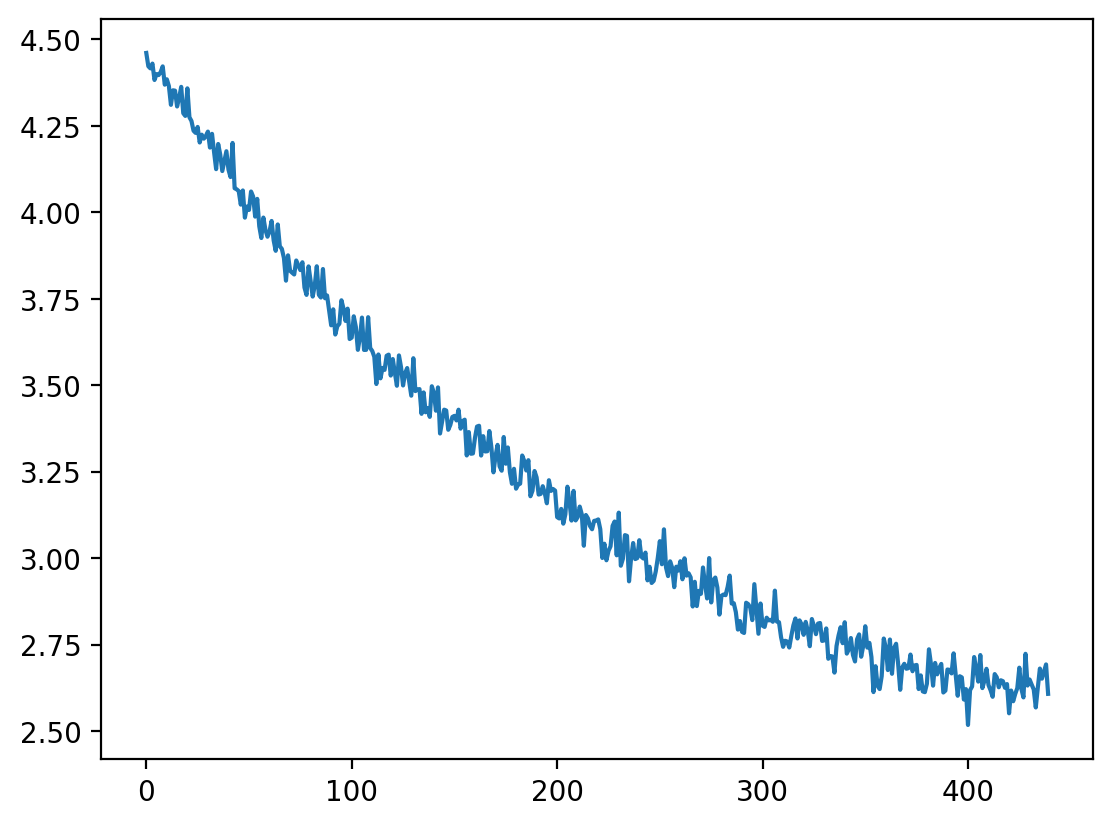

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.savefig(lossDir + '/loss_history.png')